# 多尺度目标检测
:label:`sec_multiscale-object-detection`

在 :numref:`sec_anchor`中，我们以输入图像的每个像素为中心，生成了多个锚框。
基本而言，这些锚框代表了图像不同区域的样本。
然而，如果为每个像素都生成的锚框，我们最终可能会得到太多需要计算的锚框。
想象一个$561 \times 728$的输入图像，如果以每个像素为中心生成五个形状不同的锚框，就需要在图像上标记和预测超过200万个锚框（$561 \times 728 \times 5$）。

## 多尺度锚框
:label:`subsec_multiscale-anchor-boxes`

减少图像上的锚框数量并不困难。
比如，我们可以在输入图像中均匀采样一小部分像素，并以它们为中心生成锚框。
此外，在不同尺度下，我们可以生成不同数量和不同大小的锚框。
直观地说，比起较大的目标，较小的目标在图像上出现的可能性更多样。
例如，$1 \times 1$、$1 \times 2$和$2 \times 2$的目标可以分别以4、2和1种可能的方式出现在$2 \times 2$图像上。
因此，当使用较小的锚框检测较小的物体时，我们可以采样更多的区域，而对于较大的物体，我们可以采样较少的区域。

为了演示如何在多个尺度下生成锚框，让我们先读取一张图像。
它的高度和宽度分别为561和728像素。


In [1]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
# from d2l import torch as d2l

img = plt.imread('../img/catdog.jpg')
h, w = img.shape[:2]
h, w

(561, 728)

回想一下，在 :numref:`sec_conv_layer`中，我们将卷积图层的二维数组输出称为特征图。
通过定义特征图的形状，我们可以确定任何图像上均匀采样锚框的中心。

`display_anchors`函数定义如下。
我们[**在特征图（`fmap`）上生成锚框（`anchors`），每个单位（像素）作为锚框的中心**]。
由于锚框中的$(x, y)$轴坐标值（`anchors`）已经被除以特征图（`fmap`）的宽度和高度，因此这些值介于0和1之间，表示特征图中锚框的相对位置。

由于锚框（`anchors`）的中心分布于特征图（`fmap`）上的所有单位，因此这些中心必须根据其相对空间位置在任何输入图像上*均匀*分布。
更具体地说，给定特征图的宽度和高度`fmap_w`和`fmap_h`，以下函数将*均匀地*对任何输入图像中`fmap_h`行和`fmap_w`列中的像素进行采样。
以这些均匀采样的像素为中心，将会生成大小为`s`（假设列表`s`的长度为1）且宽高比（`ratios`）不同的锚框。


In [2]:
def set_figsize(figsize=(3.5, 2.5)):
    """设置图表大小"""
    plt.rcParams['figure.figsize'] = figsize

#@save
def multibox_prior(data, sizes, ratios):
    """生成以每个像素为中心具有不同形状的锚框"""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    # 为了将锚点移动到像素的中心，需要设置偏移量。
    # 因为一个像素的高为1且宽为1，我们选择偏移我们的中心0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # 在y轴上缩放步长
    steps_w = 1.0 / in_width  # 在x轴上缩放步长

    # 生成锚框的所有中心点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # 生成“boxes_per_pixel”个高和宽，
    # 之后用于创建锚框的四角坐标(xmin,xmax,ymin,ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # 处理矩形输入
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # 除以2来获得半高和半宽
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # 每个中心点都将有“boxes_per_pixel”个锚框，
    # 所以生成含所有锚框中心的网格，重复了“boxes_per_pixel”次
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

from matplotlib.patches import Rectangle

#@save
def bbox_to_rect(bbox, color):
    """
    将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    ((左上x,左上y),宽,高)
    """
    return Rectangle(
        xy=(bbox[0], bbox[1]), 
        width=bbox[2]-bbox[0], 
        height=bbox[3]-bbox[1],
        fill=False, 
        edgecolor=color, 
        linewidth=2
    )

#@save
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

In [3]:
def display_anchors(fmap_w, fmap_h, s):
    set_figsize()
    # 前两个维度上的值不影响输出
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    show_bboxes(plt.imshow(img).axes,
                    anchors[0] * bbox_scale)

首先，让我们考虑[**探测小目标**]。
为了在显示时更容易分辨，在这里具有不同中心的锚框不会重叠：
锚框的尺度设置为0.15，特征图的高度和宽度设置为4。
我们可以看到，图像上4行和4列的锚框的中心是均匀分布的。


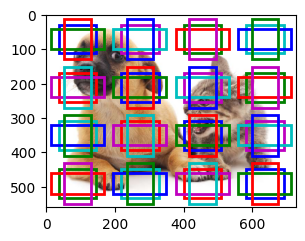

In [11]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

然后，我们[**将特征图的高度和宽度减小一半，然后使用较大的锚框来检测较大的目标**]。
当尺度设置为0.4时，一些锚框将彼此重叠。


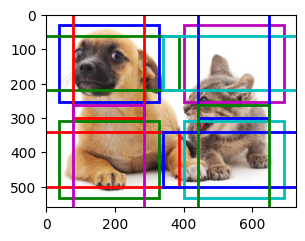

In [8]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

最后，我们进一步[**将特征图的高度和宽度减小一半，然后将锚框的尺度增加到0.8**]。
此时，锚框的中心即是图像的中心。


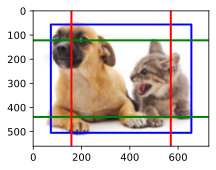

In [5]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

## 多尺度检测

既然我们已经生成了多尺度的锚框，我们就将使用它们来检测不同尺度下各种大小的目标。
下面，我们介绍一种基于CNN的多尺度目标检测方法，将在 :numref:`sec_ssd`中实现。

在某种规模上，假设我们有$c$张形状为$h \times w$的特征图。
使用 :numref:`subsec_multiscale-anchor-boxes`中的方法，我们生成了$hw$组锚框，其中每组都有$a$个中心相同的锚框。
例如，在 :numref:`subsec_multiscale-anchor-boxes`实验的第一个尺度上，给定10个（通道数量）$4 \times 4$的特征图，我们生成了16组锚框，每组包含3个中心相同的锚框。
接下来，每个锚框都根据真实值边界框来标记了类和偏移量。
在当前尺度下，目标检测模型需要预测输入图像上$hw$组锚框类别和偏移量，其中不同组锚框具有不同的中心。


假设此处的$c$张特征图是CNN基于输入图像的正向传播算法获得的中间输出。
既然每张特征图上都有$hw$个不同的空间位置，那么相同空间位置可以看作含有$c$个单元。
根据 :numref:`sec_conv_layer`中对感受野的定义，特征图在相同空间位置的$c$个单元在输入图像上的感受野相同：
它们表征了同一感受野内的输入图像信息。
因此，我们可以将特征图在同一空间位置的$c$个单元变换为使用此空间位置生成的$a$个锚框类别和偏移量。
本质上，我们用输入图像在某个感受野区域内的信息，来预测输入图像上与该区域位置相近的锚框类别和偏移量。

当不同层的特征图在输入图像上分别拥有不同大小的感受野时，它们可以用于检测不同大小的目标。
例如，我们可以设计一个神经网络，其中靠近输出层的特征图单元具有更宽的感受野，这样它们就可以从输入图像中检测到较大的目标。

简言之，我们可以利用深层神经网络在多个层次上对图像进行分层表示，从而实现多尺度目标检测。
在 :numref:`sec_ssd`，我们将通过一个具体的例子来说明它是如何工作的。

## 小结

* 在多个尺度下，我们可以生成不同尺寸的锚框来检测不同尺寸的目标。
* 通过定义特征图的形状，我们可以决定任何图像上均匀采样的锚框的中心。
* 我们使用输入图像在某个感受野区域内的信息，来预测输入图像上与该区域位置相近的锚框类别和偏移量。
* 我们可以通过深入学习，在多个层次上的图像分层表示进行多尺度目标检测。

## 练习

1. 根据我们在 :numref:`sec_alexnet`中的讨论，深度神经网络学习图像特征级别抽象层次，随网络深度的增加而升级。在多尺度目标检测中，不同尺度的特征映射是否对应于不同的抽象层次？为什么？
1. 在 :numref:`subsec_multiscale-anchor-boxes`中的实验里的第一个尺度（`fmap_w=4, fmap_h=4`）下，生成可能重叠的均匀分布的锚框。
1. 给定形状为$1 \times c \times h \times w$的特征图变量，其中$c$、$h$和$w$分别是特征图的通道数、高度和宽度。怎样才能将这个变量转换为锚框类别和偏移量？输出的形状是什么？


[Discussions](https://discuss.d2l.ai/t/2948)
